In [1]:
import time

import pandas as pd
import torch
from torch import Tensor
torch.manual_seed(0)
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()


def closure():
        optimizer.zero_grad()
        y_hat = model.forward(X_train)
        loss = criterion(y_hat, y_train)
        loss.backward()
        return loss
    
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()

import numpy as np
from sklearn.model_selection import GridSearchCV

from copy import deepcopy

data = pd.read_csv('Proj1ReorderedRound.csv')

import warnings
warnings.filterwarnings('ignore')

In [2]:
X = data.drop('Condition', axis=1).values
y = data['Condition'].values

y = LE.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = stdscaler.fit_transform(X_train)
X_test = stdscaler.transform(X_test)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [3]:
class ANN(nn.Module):
    def __init__(self,solver):
        super().__init__()
        
        if (solver == 'SGD'):
            self.fc1 = nn.Linear(in_features = 12, out_features = 8)
            self.output = nn.Linear(in_features=8, out_features=3)
            
        if (solver == 'LBFGS'):
            self.fc1 = nn.Linear(in_features = 12, out_features = 11)
            self.fc2 = nn.Linear(in_features = 11, out_features = 9)
            self.output = nn.Linear(in_features=9, out_features=3)
        
        if (solver == 'Adam'):
            self.fc1 = nn.Linear(in_features = 12, out_features = 8)
            self.fc2 = nn.Linear(in_features = 8, out_features = 4)
            self.fc3 = nn.Linear(in_features = 4, out_features = 10)
            self.output = nn.Linear(in_features=10, out_features=3)
        
        self.solver = solver
 
    def forward(self, x):
        
        if (solver == 'SGD'):
            x = F.selu(self.fc1(x))
            x = self.output(x)
            
        if (solver == 'LBFGS'):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.output(x)
        
        if (solver == 'Adam'):
            x = F.selu(self.fc1(x))
            x = F.selu(self.fc2(x))
            x = F.selu(self.fc3(x))
            x = self.output(x)
        
        return x
    
criterion = nn.CrossEntropyLoss()

In [4]:
initiator = 0

solver = 'SGD'

if (solver == 'Adam'):
    af = 'selu'
    layers = 3

if (solver == 'LBFGS'):
    af = 'relu'
    layers = 2
    
if (solver == 'SGD'):
    af = 'selu'
    layers = 1
    


In [5]:
Abase = 1

Range = []
stage = 1

for i in range(-10,11):
    x = np.round(Abase + i*(10**(-stage)),stage)
    if (x>0):
        Range.append(x)

Range

[0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0]

In [6]:
time_list = []
index = 0
I = 0
Abase = 1

LossDF = pd.DataFrame(columns = ['alpha','initial','final','epoch to converge'])

if (initiator == 0):   
    FML = []
    
for i in range(4):
    stage = i+1

    Range = []
    
    tempDF = pd.DataFrame(columns = ['alpha','initial','final','epoch to converge'])

    for i in range(-10,11):
        x = np.round(Abase + i*(10**(-stage)),stage)
        if (x>0):
            Range.append(x)
    
    for A in Range:
    
        if (initiator == 0):
            model = ANN(solver)
            dummy = deepcopy(model)
            FML.append(dummy)
            initiator = 1
        
        elif (initiator == 1):
            model = deepcopy(FML[0])
    
        Start = time.time()
        
        to_add = []
        to_add.append(A)
        
        epochs = 0
        
        if (solver == 'Adam'):
            optimizer = torch.optim.Adam(model.parameters(), lr=A) # ADAM
        if (solver == 'LBFGS'):
            optimizer = torch.optim.LBFGS(model.parameters(), lr=A) # LBFGS
        if (solver == 'SGD'):
            optimizer = torch.optim.SGD(model.parameters(), lr=A) # SGD
            
        loss = 1
        lossT = loss
        
        while (lossT > 0.0001):
            y_hat = model.forward(X_train)
            loss = criterion(y_hat, y_train)
            optimizer.zero_grad()
            loss.backward()
            
            if (solver == 'LBFGS'):
                optimizer.step(closure)
            
            else:
                optimizer.step()
                
            epochs += 1
            
            lossT = loss.detach().numpy()
            
            if (epochs == 1):
                to_add.append(lossT)
                
            if (epochs > 1000):
                lossT = 0
                
                
        to_add.append(loss.detach().numpy())
        to_add.append(epochs)
        
        tempDF.loc[index] = to_add
        index += 1
    
        End = time.time()
        dura = End - Start
        time_list.append(dura)
    
        print('\nComputation for learning rate = ',A,'complete')
        print('Time taken : ', np.round(dura,3),'s')
        
        Abase = tempDF.sort_values(by = 'final')['alpha'].iloc[0]
    
    LossDF.loc[I] = tempDF.sort_values(by = 'epoch to converge').iloc[0]
    I += 1

print('\nSolver : ', solver)
print('Activation function : ', af)

print('\nTotal time taken :',np.round(np.sum(time_list),3),'s')
alphaList = LossDF['alpha']

LossDF


Computation for learning rate =  0.1 complete
Time taken :  0.35 s

Computation for learning rate =  0.2 complete
Time taken :  0.328 s

Computation for learning rate =  0.3 complete
Time taken :  0.324 s

Computation for learning rate =  0.4 complete
Time taken :  0.335 s

Computation for learning rate =  0.5 complete
Time taken :  0.367 s

Computation for learning rate =  0.6 complete
Time taken :  0.348 s

Computation for learning rate =  0.7 complete
Time taken :  0.333 s

Computation for learning rate =  0.8 complete
Time taken :  0.331 s

Computation for learning rate =  0.9 complete
Time taken :  0.346 s

Computation for learning rate =  1.0 complete
Time taken :  0.349 s

Computation for learning rate =  1.1 complete
Time taken :  0.354 s

Computation for learning rate =  1.2 complete
Time taken :  0.362 s

Computation for learning rate =  1.3 complete
Time taken :  0.318 s

Computation for learning rate =  1.4 complete
Time taken :  0.334 s

Computation for learning rate =  1

,alpha,initial,final,epoch to converge
0,0.100,1.2196867,0.011553396,1001
1,1.900,1.2196867,0.00026075664,1001
2,2.090,1.2196867,0.00023319715,1001
3,2.109,1.2196867,0.00023049551,1001



Computation for learning rate =  0.1 complete
Time taken :  15.719 s

Computation for learning rate =  1.9 complete
Time taken :  0.802 s

Computation for learning rate =  2.09 complete
Time taken :  0.735 s

Computation for learning rate =  2.109 complete
Time taken :  0.737 s

Solver :  SGD
Activation function :  selu

Total time taken : 17.993 s


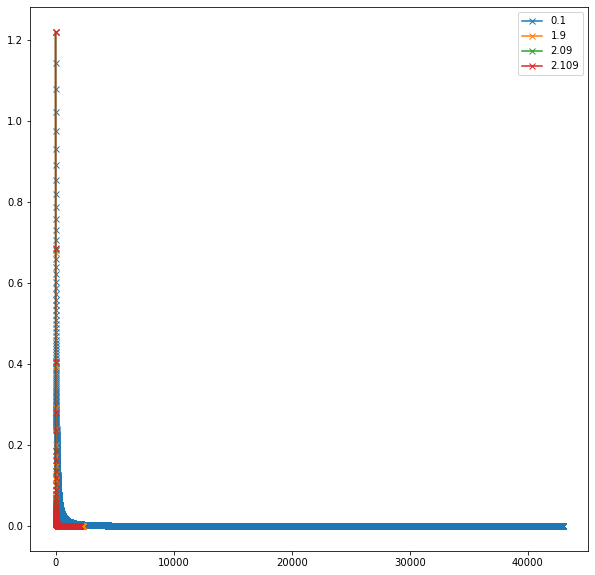

In [7]:
lossList = []

time_list = []

if (initiator == 0):   
    FML = []
    
for A in alphaList:
    
    if (initiator == 0):
        model = ANN(solver)
        dummy = deepcopy(model)
        FML.append(dummy)
        initiator = 1
        
    elif (initiator == 1):
        model = deepcopy(FML[0])
    
    Start = time.time()
        
    to_add = []
        
    if (solver == 'Adam'):
        optimizer = torch.optim.Adam(model.parameters(), lr=A) # ADAM
    if (solver == 'LBFGS'):
        optimizer = torch.optim.LBFGS(model.parameters(), lr=A) # LBFGS
    if (solver == 'SGD'):
        optimizer = torch.optim.SGD(model.parameters(), lr=A) # SGD
            
    loss = 1
    lossT = loss
        
    while (lossT > 0.0001):
        y_hat = model.forward(X_train)
        loss = criterion(y_hat, y_train)
        optimizer.zero_grad()
        loss.backward()
            
        if (solver == 'LBFGS'):
            optimizer.step(closure)
            
        else:
            optimizer.step()
                     
        to_add.append(loss.detach().numpy())
        
        lossT = loss.detach().numpy()
        
    to_add.append(loss.detach().numpy())
    
    End = time.time()
    dura = End - Start
    time_list.append(dura)
    
    print('\nComputation for learning rate = ',A,'complete')
    print('Time taken : ', np.round(dura,3),'s')
    
    lossList.append(to_add)

print('\nSolver : ', solver)
print('Activation function : ', af)

print('\nTotal time taken :',np.round(np.sum(time_list),3),'s')

plt.figure(figsize = (10,10)) 

for line in lossList:
    plt.plot(line,'-x')
    
plt.legend(alphaList)

In [8]:
time_list = []
index = 0
I = 0
Abase = 1

LossDF = pd.DataFrame(columns = ['alpha','initial','final','epoch to converge'])

if (initiator == 0):   
    FML = []
    
for i in range(4):
    stage = i+1

    Range = []
    
    tempDF = pd.DataFrame(columns = ['alpha','initial','final','epoch to converge'])

    for i in range(-10,11):
        x = np.round(Abase + i*(10**(-stage)),stage)
        if (x>0):
            Range.append(x)
    
    for A in Range:
    
        if (initiator == 0):
            model = ANN(solver)
            dummy = deepcopy(model)
            FML.append(dummy)
            initiator = 1
        
        elif (initiator == 1):
            model = deepcopy(FML[0])
    
        Start = time.time()
        
        to_add = []
        to_add.append(A)
        
        epochs = 0
        
        if (solver == 'Adam'):
            optimizer = torch.optim.Adam(model.parameters(), lr=A) # ADAM
        if (solver == 'LBFGS'):
            optimizer = torch.optim.LBFGS(model.parameters(), lr=A) # LBFGS
        if (solver == 'SGD'):
            optimizer = torch.optim.SGD(model.parameters(), lr=A) # SGD
            
        loss = 1
        lossT = loss
        
        while (lossT > 0.0001):
            y_hat = model.forward(X_train)
            loss = criterion(y_hat, y_train)
            optimizer.zero_grad()
            loss.backward()
            
            if (solver == 'LBFGS'):
                optimizer.step(closure)
            
            else:
                optimizer.step()
                
            epochs += 1
            
            lossT = loss.detach().numpy()
            
            if (epochs == 1):
                to_add.append(lossT)
                
            if (epochs > 1000):
                lossT = 0
                
                
        to_add.append(loss.detach().numpy())
        to_add.append(epochs)
        
        tempDF.loc[index] = to_add
        index += 1
    
        End = time.time()
        dura = End - Start
        time_list.append(dura)
    
        print('\nComputation for learning rate = ',A,'complete')
        print('Time taken : ', np.round(dura,3),'s')
        
        Abase = tempDF.sort_values(by = 'epoch to converge')['alpha'].iloc[0]
        
    LossDF.loc[I] = tempDF.sort_values(by = 'epoch to converge').iloc[0]
    I += 1

print('\nSolver : ', solver)
print('Activation function : ', af)

print('\nTotal time taken :',np.round(np.sum(time_list),3),'s')
alphaList = LossDF['alpha']

LossDF


Computation for learning rate =  0.1 complete
Time taken :  0.371 s

Computation for learning rate =  0.2 complete
Time taken :  0.362 s

Computation for learning rate =  0.3 complete
Time taken :  0.363 s

Computation for learning rate =  0.4 complete
Time taken :  0.365 s

Computation for learning rate =  0.5 complete
Time taken :  0.361 s

Computation for learning rate =  0.6 complete
Time taken :  0.382 s

Computation for learning rate =  0.7 complete
Time taken :  0.385 s

Computation for learning rate =  0.8 complete
Time taken :  0.373 s

Computation for learning rate =  0.9 complete
Time taken :  0.369 s

Computation for learning rate =  1.0 complete
Time taken :  0.367 s

Computation for learning rate =  1.1 complete
Time taken :  0.361 s

Computation for learning rate =  1.2 complete
Time taken :  0.36 s

Computation for learning rate =  1.3 complete
Time taken :  0.361 s

Computation for learning rate =  1.4 complete
Time taken :  0.361 s

Computation for learning rate =  1

,alpha,initial,final,epoch to converge
0,0.1000,1.2196867,0.011553396,1001
1,0.0100,1.2196867,0.19958918,1001
2,0.0010,1.2196867,0.75844693,1001
3,0.0001,1.2196867,1.1453058,1001


In [9]:
lossList = []

time_list = []

if (initiator == 0):   
    FML = []
    
for A in alphaList:
    
    if (initiator == 0):
        model = ANN(solver)
        dummy = deepcopy(model)
        FML.append(dummy)
        initiator = 1
        
    elif (initiator == 1):
        model = deepcopy(FML[0])
    
    Start = time.time()
        
    to_add = []
        
    if (solver == 'Adam'):
        optimizer = torch.optim.Adam(model.parameters(), lr=A) # ADAM
    if (solver == 'LBFGS'):
        optimizer = torch.optim.LBFGS(model.parameters(), lr=A) # LBFGS
    if (solver == 'SGD'):
        optimizer = torch.optim.SGD(model.parameters(), lr=A) # SGD
            
    loss = 1
    lossT = loss
        
    while (lossT > 0.0001):
        y_hat = model.forward(X_train)
        loss = criterion(y_hat, y_train)
        optimizer.zero_grad()
        loss.backward()
            
        if (solver == 'LBFGS'):
            optimizer.step(closure)
            
        else:
            optimizer.step()
                     
        to_add.append(loss.detach().numpy())
        
        lossT = loss.detach().numpy()
        
    to_add.append(loss.detach().numpy())
    
    End = time.time()
    dura = End - Start
    time_list.append(dura)
    
    print('\nComputation for learning rate = ',A,'complete')
    print('Time taken : ', np.round(dura,3),'s')
    
    lossList.append(to_add)

print('\nSolver : ', solver)
print('Activation function : ', af)

print('\nTotal time taken :',np.round(np.sum(time_list),3),'s')

plt.figure(figsize = (10,10)) 

for line in lossList:
    plt.plot(line,'-x')
    
plt.legend(alphaList)


Computation for learning rate =  0.1 complete
Time taken :  15.642 s

Computation for learning rate =  0.01 complete
Time taken :  159.697 s


KeyboardInterrupt: 

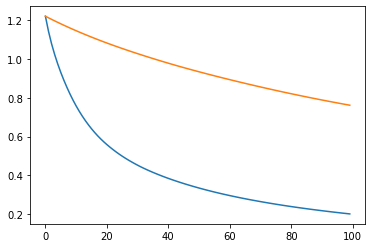

In [14]:
plt.plot(lossList[0][:100])
plt.plot(lossList[1][:100])
